In [1]:
import numpy as np, pandas as pd
from collections import defaultdict, Counter

In [2]:
train = pd.read_csv('ctcf_ml_datasets/train_dinuc.tsv', sep='\t', header=None)
train

,0,1,2,3,4
0,CTCCTCAGTTTCTCTGTGCAGCACCAGGTGGCAGCAGAGGTCAGCA...,1,chr1,267981,268031
1,CCCTCCCGCGGCTCCGGAGCCGGCTGCCACCAGGGGGCGCGCCCGC...,1,chr1,869894,869944
2,CACTCCGCCACCAGGGGGCGCCACAGCTCCTCGCGCCGCCGCCTCC...,1,chr1,904763,904813
3,TCCTGCTTGGGGCAGCGTGGAGGCCAGCGGAGGAACTGCAGGAGCC...,1,chr1,913001,913051
4,TCCTCCCTCTGGCGGCGGGAGGcaggctccagcctcagcccagcGG...,1,chr1,921192,921242
...,...,...,...,...,...
3795,GTGCACACAGTGTGCGGCTGTGGTGACGCCCTTATTCTCCTCCAGA...,0,chr19,2951162,2951212
3796,atgaaCACAGGGCAGACCACTATGACCATGCGTCAATTTTTGGAAA...,0,chr19,2956589,2956639
3797,CATCAATTCCCTACATTAGATTGACAAGGAGGCTGGTAGGTTATAC...,0,chr19,2962235,2962285
3798,GGTTTGGAGGGGCGGAGAGTCCAGGGGCCCTCCAGCTGCCCGATCC...,0,chr19,3057552,3057602


In [3]:
train_seqs = [seq.upper() for seq in train[0]]
len(train_seqs)

3800

In [4]:
def build_kmer_vocab(seqs, k=6):
    # Build vocab FIRST from ALL sequences
    seqs = [s.upper() for s in seqs]
    all_kmers = set()
    for s in seqs:
        for i in range(len(s)-k+1):
            all_kmers.add(s[i:i+k])
    vocab = sorted(all_kmers)  # ~1000-4000 for real data
    kmer_idx = {kmer: i for i, kmer in enumerate(vocab)}
    return vocab, kmer_idx

def kmer_matrix(seqs, kmer_idx, k=6):
    n = len(seqs)
    d = len(kmer_idx)
    X = np.zeros((n,d), dtype=np.float32)
    for i, seq in enumerate(seqs):
        counts = Counter(seq[j:j+k] for j in range(len(seq)-k+1))
        for kmer, count in counts.items():
            idx = kmer_idx.get(kmer)
            if idx is not None:
                X[i, idx] = count
    return X

In [5]:
vocab, train_kmer_idx = build_kmer_vocab(train_seqs)
len(vocab), len(train_kmer_idx)

(4093, 4093)

In [6]:
x_trn_k = kmer_matrix(train_seqs, train_kmer_idx)
x_trn_k.shape

(3800, 4093)

In [7]:
def one_hot(seqs, seq_len):
    X = np.zeros((len(seqs), 4*seq_len))
    base_map = {'A':0, 'C':1, 'G':2, 'T':3}
    for i, seq in enumerate(seqs):
        seq = seq.upper()
        for j, base in enumerate(seq):
            X[i, j*4 + base_map[base]] = 1
    return X

In [8]:
x_trn_enc = one_hot(train_seqs)
x_trn_enc.shape

(3800, 200)

In [9]:
x_train = np.hstack([x_trn_k,x_trn_enc])
x_train.shape

(3800, 4293)

In [10]:
y_train = np.array(train[1])
y_train.shape

(3800,)

In [11]:
y_train[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [12]:
from torch import tensor
import torch

idx = torch.randperm(x_train.shape[0])
x_train, y_train = x_train[idx], y_train[idx]
x_train.shape, y_train[:10]

((3800, 4293), array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0]))

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV

In [14]:
x_train[:,0].mean(), x_train[:,0].std()

(0.016842105263157894, 0.21332092530859517)

In [16]:
param_grid = {'C': [0.01, 0.1, 1, 2]}
unscaled_grid = GridSearchCV(
LinearSVC(max_iter=10000, dual=False),
param_grid, 
scoring="average_precision",
cv=5)

In [17]:
unscaled_grid.fit(x_train, y_train)

,estimator,LinearSVC(dua...ax_iter=10000)
,param_grid,"{'C': [0.01, 0.1, ...]}"
,scoring,'average_precision'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [18]:
unscaled_grid.best_score_, unscaled_grid.best_params_

(0.7884614777180846, {'C': 0.01})

In [19]:
test = pd.read_csv('ctcf_ml_datasets/test_dinuc.tsv', sep='\t', header=None)
test

,0,1,2,3,4
0,GGCCTGCAAAATATCCTGTAACTCCTCTAGAGGGTGCTCACTAGCA...,1,chr20,209112,209162
1,GTGCCAGTCTCTACCGCCATCTGCCGGCAGCACTCGGTACACCCGC...,1,chr20,267130,267180
2,GCCAGCGTCTCGGTCTCCAAGGAAACGCGACGCCGCCTACCGAGCG...,1,chr20,290750,290800
3,TGGGGTCTCTGGGGCCACCTAGTGGCTAAGAGGAGTAGAACCAAGG...,1,chr20,330740,330790
4,gAGGCGTCATCTCTCTTCTGTACCACTAGAGGGAGCTCTGATGCAG...,1,chr20,354618,354668
...,...,...,...,...,...
795,AAGCCAAGGTGTAGCACCCCGGGTCAATATGCTGATAACCAATTGC...,0,chrX,14039481,14039531
796,TCAGACGTGCATGGCACCAGTGAGCCGCAGGTGAACAGATGTTCTG...,0,chrX,14095821,14095871
797,CTCCCGCTGTTTGAGAATTGGAGCCATGAACAGGAGCAAAGAAGGC...,0,chrX,14528864,14528914
798,ACCTTTACAGGCTGTCTGCACCCTCCTATGTGATACTGCCTGGGCA...,0,chrX,14697644,14697694


In [20]:
test_seqs = [seq.upper() for seq in test[0]]

In [21]:
x_test_k = kmer_matrix(test_seqs, train_kmer_idx)
x_test_enc = one_hot(test_seqs)
x_test_k.shape, x_test_enc.shape

((800, 4093), (800, 200))

In [22]:
x_test = np.hstack([x_test_k,x_test_enc])
y_test = np.array(test[1])
x_test.shape, y_test.shape, y_test[:10]

((800, 4293), (800,), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [23]:
x_test[:,0].mean(), x_test[:,0].std()

(0.0175, 0.17231874535290692)

In [24]:
from modules.svm import *

get_metrics(unscaled_grid, x_test, y_test)

Accuracy: 0.73125
AUROC: 0.8160125
AUPRC: 0.8248145586133082


## Scaling worsens performance

`StandardScaler` scales each feature to have `mean=0` and `std=1`. 

In [25]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(max_iter=10000, class_weight='balanced'))
])

scaled_grid = GridSearchCV(pipe, {'svc__C': [0.01, 0.1, 1, 2]}, cv=5, scoring='average_precision')

In [26]:
scaled_grid.fit(x_train, y_train)

,estimator,Pipeline(step...iter=10000))])
,param_grid,"{'svc__C': [0.01, 0.1, ...]}"
,scoring,'average_precision'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [27]:
scaled_grid.best_score_, scaled_grid.best_params_

(0.6941965284795095, {'svc__C': 0.01})

In [28]:
x_test[:,0].mean(), x_test[:,0].std()

(0.0175, 0.17231874535290692)

Test set is automatically scaled with trained `scaler` inside model:

In [29]:
get_metrics(scaled_grid, x_test, y_test)

Accuracy: 0.67
AUROC: 0.7420125
AUPRC: 0.7331998753341953


## Feature importances

In [33]:
best_svc = unscaled_grid.best_estimator_

# Raw coefficient magnitudes = feature importance
importances = np.abs(best_svc.coef_[0])  # shape (4293,)

# Get feature names
onehot_names = [f"pos{j}_{base}" for j in range(50) for base in "ACGT"]  # 200 names
kmer_names = list(train_kmer_idx.keys())  # your ~4093 kmers
all_names = onehot_names + kmer_names

# Top 20 most important
top_idx = np.argsort(importances)[-20:]
for i in top_idx:
    print(f"{importances[i]:.3f}: {all_names[i]}")


0.171: GTAGAC
0.172: GAGCCC
0.175: CCACCA
0.177: CGCGCG
0.181: CACGTT
0.187: ATGTGG
0.187: ACTTAG
0.189: CGCCGG
0.190: CAGATC
0.190: GTTGCG
0.194: GTTAAG
0.198: CTTGAC
0.199: CCACCC
0.205: ATGAGG
0.222: CAGATT
0.257: CACATT
0.261: CAGGTT
0.261: GGAGAC
0.283: GCTGAG
0.340: ACTGAG


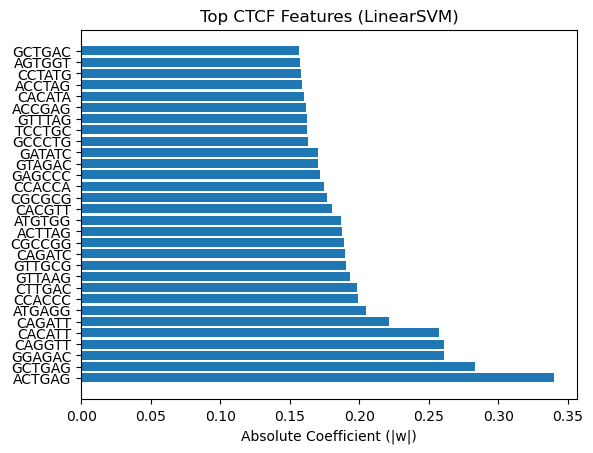

In [37]:
import matplotlib.pyplot as plt
top_idx = np.argsort(importances)[-30:]
plt.barh(range(30), importances[top_idx])
plt.yticks(range(30), [all_names[i] for i in top_idx])
plt.xlabel("Absolute Coefficient (|w|)")
plt.title("Top CTCF Features (LinearSVM)")
plt.gca().invert_yaxis()
plt.show()

In [50]:
(best_svc.coef_[0][:200]).min(), (best_svc.coef_[0][:200]).max()

(-0.1367791855911927, 0.13779402900394613)

In [51]:
(best_svc.coef_[0][200:]).min(), (best_svc.coef_[0][200:]).max()

(-0.28333108249084954, 0.3398015748750346)

In [39]:
# Method 2: Normalized by feature std (scale-invariant)
feature_stds = x_train.std(axis=0)
norm_importance = np.abs(best_svc.coef_[0]) / (feature_stds + 1e-8)

In [40]:
# Method 3: Top % of each feature type separately
kmer_importance = norm_importance[200:]  # k-mers only
onehot_importance = norm_importance[:200]  # one-hot only

top_kmers = np.argsort(kmer_importance)[-20:] + 200
print("Top normalized k-mers:")
for i in top_kmers:
    print(f"{norm_importance[i]:.4f}: {all_names[i]}")

Top normalized k-mers:
1.5519: CCCGTG
1.5568: AATGTG
1.5582: AATAAG
1.5679: CTCCTG
1.5813: CGCTAA
1.5863: CGCCCA
1.5938: CGATAG
1.6149: CGAAAA
1.6183: CACACC
1.6312: TTAATG
1.6426: CCTGGC
1.6696: GTGCGG
1.6940: AGTGGT
1.6950: AGTTTA
1.7226: ACCCAC
1.7351: TGGGAG
1.7887: CTTACC
1.8521: CAGGCC
1.8846: CGAATA
2.0770: CCGTGC


In [42]:
ctcf_patterns = ['CCG', 'GGN', 'GGC', 'CCN', 'NGG']
hits = []
for i, name in enumerate(all_names[200:], 200):
    if any(p in name for p in ctcf_patterns):
        hits.append((norm_importance[i], name))
print("Top CTCF fragments:", sorted(hits, reverse=True)[:10])

Top CTCF fragments: [(2.077038085159457, 'CCGTGC'), (1.8521480245273847, 'CAGGCC'), (1.6425625998051243, 'CCTGGC'), (1.5518718043727562, 'CCCGTG'), (1.5393303134635858, 'CCGCTA'), (1.5272072933468626, 'ACAGGC'), (1.4332802744941657, 'AGGGCA'), (1.3342986058745792, 'TGGGGC'), (1.2933808375810787, 'GAAGGC'), (1.264180458437569, 'CAGGCA')]


In [57]:
x_test[:,0].mean(), x_test[:,0].std()

(0.0175, 0.17231874535290692)

In [58]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, roc_auc_score

# Compute permutation importance on TEST set (NOT train!)
perm_importance = permutation_importance(
    best_svc, 
    x_test,           # Raw test features
    y_test,                    # True test labels
    scoring='average_precision',         # Your metric
    n_repeats=10,              # Repeat shuffle 10x for stability
    random_state=42,
    n_jobs=-1                  # Parallel
)

# Results: mean/std importance per feature
mean_importance = perm_importance.importances_mean  # (4293,)
std_importance = perm_importance.importances_std    # (4293,)

# Top 20 features (model-agnostic, unbiased!)
top20_idx = np.argsort(mean_importance)[-20:]
for i in top20_idx:
    print(f"{mean_importance[i]:.4f} ± {std_importance[i]:.4f}: {all_names[i]}")

0.0022 ± 0.0012: CGTCCG
0.0023 ± 0.0009: CGTGCG
0.0029 ± 0.0006: TCTTAG
0.0031 ± 0.0012: CACATA
0.0032 ± 0.0014: CACGTT
0.0033 ± 0.0010: CCACCA
0.0037 ± 0.0010: GACTTC
0.0038 ± 0.0017: ACCGAG
0.0039 ± 0.0026: CAGATT
0.0042 ± 0.0017: GAGCCC
0.0044 ± 0.0008: CAGATC
0.0045 ± 0.0016: ATGAGG
0.0049 ± 0.0014: GTTTAG
0.0051 ± 0.0013: CTTGAC
0.0056 ± 0.0013: GCTGAC
0.0060 ± 0.0016: CGCGCG
0.0069 ± 0.0023: CACATT
0.0070 ± 0.0025: GGAGAC
0.0099 ± 0.0039: CAGGTT
0.0143 ± 0.0022: ACTGAG


In [64]:
baseline_auc = roc_auc_score(y_test, unscaled_grid.predict(x_test))
print(f"Baseline test AUROC: {baseline_auc:.4f}")  # Should match your 0.82

Baseline test AUROC: 0.7312


In [63]:
best_svc

,penalty,'l2'
,loss,'squared_hinge'
,dual,False
,tol,0.0001
,C,0.01
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [66]:
import pandas as pd
fimo_df = pd.read_csv('fimo_out_pos/fimo.tsv', sep='\t')

# Significant hits (p < 1e-4)
sig_hits = fimo_df[fimo_df['p-value'] < 1e-4]
print(f"Significant CTCF motif hits: {len(sig_hits)}")

# % unique peaks with motif
unique_peaks = sig_hits['sequence_name'].nunique()
total_peaks = 1150 # Your total sequences
print(f"% peaks with motif: {100 * unique_peaks / total_peaks:.1f}%")

Significant CTCF motif hits: 1103
% peaks with motif: 94.5%
